
# 1D Inversion of for a Single Sounding of Permafrost layers

**Based on:** module from *simpeg.electromangetics.frequency_domain_1d* to invert
frequency domain data and recover a 1D electrical conductivity model.

**Survey:** Forward simulation to mimic the permafrost structure of the AEM survey conducted in August, 2024, by Xcalibur Multiphysic. In the Inuvik-Tuktoyaktuk-Highway (ITH) project. Magnetic dipole at 35 m above the Earth's surface. The receiver is offset\
10 m horizontally from the source.

## Import modules




In [3]:
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import simpeg.electromagnetics.frequency_domain as fdem
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})

# sphinx_gallery_thumbnail_number = 2

## Open data from Forward Simluation



In [5]:
# Path to saved data, output folder. same directory
data_filename = os.path.join("outputs", "em1dfm_data.txt")

## Load Data and Plot

Here we load and plot the 1D sounding data. In this case, we have the
secondary field response in ppm for a set of frequencies.




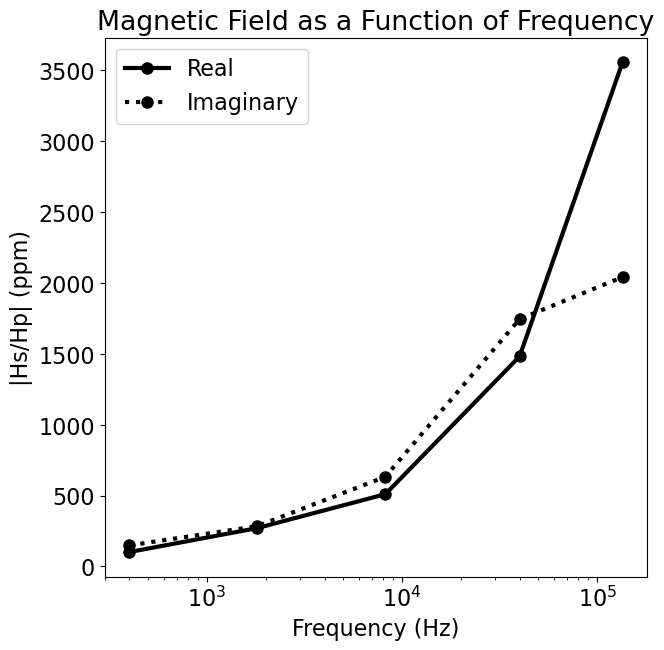

In [7]:
# Load field data
# dobs = np.loadtxt(str(data_filename))
dobs = np.loadtxt(str(data_filename), skiprows=1)

# Define receiver locations and observed data
frequencies = dobs[:, 0]
dobs = mkvc(dobs[:, 1:].T)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.semilogx(frequencies, np.abs(dobs[0::2]), "k-o", lw=3)
ax.semilogx(frequencies, np.abs(dobs[1::2]), "k:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("|Hs/Hp| (ppm)")
ax.set_title("Magnetic Field as a Function of Frequency")
ax.legend(["Real", "Imaginary"])

## Defining the Survey

Based on RESOLVE 6 system flew by by Xcalibur Multiphysic in August 2024. Nominal frequencies 135 kHz, 40 kHz, 8.2 kHz, 1.8 kHz and 400 Hz. The flight-line spacing was 100 m, and the average terrain clearance was 35 m for the RESOLVE bird.  





In [9]:
source_location = np.array([0.0, 0.0, 35.0])
moment = 1.0

receiver_location = np.array([10.0, 0.0, 35.0])
receiver_orientation = "z"
data_type = "ppm"

# Receiver list
receiver_list = []
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="real",
    )
)
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="imag",
    )
)

# Define source list
source_list = []
for freq in frequencies:
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation="z",
            moment=moment,
        )
    )

# Survey
survey = fdem.survey.Survey(source_list)

## Assign Uncertainties and Define the Data Object

Uncertainties based on noise level added on forward simulation



In [11]:
# 5% of the absolute value
uncertainties = 0.02 * np.abs(dobs) * np.ones(np.shape(dobs))

# Define the data object
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

# Define Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem





# Halfspace Inversion

## Defining a 1D Layered Earth (1D Tensor Mesh)

Here, we define the layer thicknesses for our 1D simulation. To do this, we use
the TensorMesh class.



In [15]:
### Mesh Definition for halfspace ###

layer_thick_halfspace = [10000]
n_layers_halfspace = 1

# Defining the mapping
log_conductivity_halfspace_map = maps.ExpMap(nP=n_layers_halfspace)

# Starting model is log-conductivity values (S/m)
starting_conductivity_model_hsp = np.log(1e-3 * np.ones(n_layers_halfspace))

# Reference model, same as starting 
reference_conductivity_model_hsp = starting_conductivity_model_hsp.copy()


## Define the Physics using a Simulation Object


In [17]:
simulation_hsp_L2 = fdem.Simulation1DLayered(
        survey=survey,
        thicknesses=[],
        sigmaMap=log_conductivity_halfspace_map
    )


## Data Misfit 

In [19]:
dmis_hsp_L2 = data_misfit.L2DataMisfit(simulation=simulation_hsp_L2, data=data_object)


## Regularization

In [21]:

h = np.r_[layer_thick_halfspace]

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")

reg_L2 = regularization.WeightedLeastSquares(
        regularization_mesh,
        length_scale_x=10.0,
        # reference_model=np.r_[reference_conductivity_model, reference_conductivity_model[-1]],
        reference_model=reference_conductivity_model_hsp,
        reference_model_in_smooth=False
        )

#Set regularization parameters:
reg_L2.alpha_s = 1e-5 
reg_L2.alpha_x=1 

## Optimization

In [23]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

## Inversion Parameters

In [25]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_hsp_L2, reg_L2, opt_L2)

#Set inversion directives:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=1.5, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)
save_L2_hp = directives.SaveOutputDictEveryIteration()

directives_list_L2 = [
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
    save_L2_hp
]

## Running Inversion

In [27]:
# Combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
# print(f"\n **** Running halfspace inversion for line {line_no} and station {stn}... ****")
recovered_halfspace_model_L2 = inv_L2.run(starting_conductivity_model_hsp)

## Get the recovered halfspace resistivity from model estimated
conductivities_hsp = log_conductivity_halfspace_map * recovered_halfspace_model_L2
resistivities_hsp = 1 / conductivities_hsp


Running inversion with SimPEG v0.23.1.dev1+g60e0c3a5

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.46e+04  1.77e+04  0.00e+00  1.77e+04    4.82e+03      0              
   1  2.46e+04  1.30e+04  6.65e-02  1.46e+04    2.56e+03      0              


/opt/anaconda3/lib/python3.12/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: SolverLU. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
/opt/anaconda3/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


   2  1.64e+04  1.06e+04  1.35e-01  1.29e+04    3.21e+03      0   Skip BFGS  
   3  1.64e+04  7.40e+03  2.63e-01  1.17e+04    1.50e+03      0              
   4  1.10e+04  6.35e+03  3.17e-01  9.82e+03    2.52e+03      0   Skip BFGS  
   5  1.10e+04  4.81e+03  4.17e-01  9.38e+03    7.13e+02      0              
   6  7.30e+03  4.51e+03  4.42e-01  7.74e+03    1.72e+03      0   Skip BFGS  
   7  7.30e+03  3.91e+03  5.04e-01  7.59e+03    3.42e+02      0              
   8  4.87e+03  3.82e+03  5.15e-01  6.33e+03    1.17e+03      0   Skip BFGS  
   9  4.87e+03  3.57e+03  5.55e-01  6.27e+03    1.85e+02      0              
  10  3.25e+03  3.54e+03  5.61e-01  5.36e+03    7.99e+02      0   Skip BFGS  
  11  3.25e+03  3.43e+03  5.87e-01  5.33e+03    1.08e+02      0              
  12  2.16e+03  3.42e+03  5.90e-01  4.69e+03    5.41e+02      0   Skip BFGS  
  13  2.16e+03  3.37e+03  6.07e-01  4.68e+03    6.60e+01      0              
  14  1.44e+03  3.36e+03  6.09e-01  4.24e+03    3.64e+02      0 

## Plot results

In [29]:
line_no = "fake #"
fid_n = "fake sounding"

print(f"\n **** Halfspace inversion for line {line_no} and sounding {fid_n}... ****")
print("Resistivity halfspace: ", resistivities_hsp)



 **** Halfspace inversion for line fake # and sounding fake sounding... ****
Resistivity halfspace:  [78.68680688]


# L2 Inversion

## Defining a 1D Layered Earth (1D Tensor Mesh)

Calciating the depth max based on skin depth $\delta$:
$$\delta \approx 503*\sqrt{\frac{\rho_h}{f_{min}}}$$
$$depth_{max} = 2*\delta$$

where:
* $\rho_h: $ is the expected model resisitivy (Estimated in the halfspace inversion)
* $f_{min}: $ Survey's lowest frequency

In [32]:
### Depth max ###
skin_depth = 503*np.sqrt(resistivities_hsp/np.min(frequencies))
depth_max = 2*skin_depth  # depth to lowest layer

### Mesh Definition ###
depth_min = 1                      # top layer thickness
geometric_factor = 1.2                # rate of thickness increase

#Increase layer thickness by geometric factor until depth_max
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor*layer_thicknesses[-1])

#Set number of layers
n_layers = len(layer_thicknesses) + 1  # Number of layers

### Defining the mapping ###
log_conductivity_map = maps.ExpMap(nP=n_layers)


## Set prior model

From halfspace results

In [34]:
# estimated host conductivity (S/m) from halfspace inversion
host_conductivity = 1 / resistivities_hsp[0]

# Starting model is log-conductivity values (S/m)
starting_conductivity_model = np.log(host_conductivity * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_conductivity_model = starting_conductivity_model.copy()


## Forward simulation

In [36]:
simulation_L2 = fdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    sigmaMap=log_conductivity_map
)

## Data Misfit

In [38]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

## Regularization

In [40]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
#h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")

# Define regularization
reg_L2 = regularization.WeightedLeastSquares(
        regularization_mesh,
        # smallness=1e-5
        length_scale_x=10,
        reference_model=reference_conductivity_model,
        reference_model_in_smooth=False
    )

# Define regularization parameters:
reg_L2.alpha_s = 1e-6 # alpha_s
reg_L2.alpha_x= 1 # alpha_x


## Optimization

In [42]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

## Inversion Parameters

In [44]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

#Inversion Directives
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=False)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=1.5, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)
save_L2 = directives.SaveOutputDictEveryIteration()

directives_list_L2 = [
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
    save_L2
]

## Running Inversion

In [46]:
# Combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
# print(f"\n **** Running layered inversion for line {line_no} and station {stn}... ****")
recovered_model_L2 = inv_L2.run(starting_conductivity_model)

#resistivities_L2 = 1 / (log_conductivity_map * recovered_model_L2)


Running inversion with SimPEG v0.23.1.dev1+g60e0c3a5

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.19e+03  3.32e+03  1.64e-31  3.32e+03    7.88e+02      0              
   1  1.19e+03  8.56e+02  3.88e-01  1.32e+03    5.65e+02      0              
   2  7.93e+02  4.61e+02  2.28e-01  6.42e+02    2.48e+02      0              
   3  7.93e+02  2.99e+02  3.45e-01  5.72e+02    4.40e+01      0              
   4  5.29e+02  3.12e+02  3.26e-01  4.84e+02    7.34e+01      0              
   5  5.29e+02  2.29e+02  4.60e-01  4.72e+02    4.65e+01 

## Plotting results:

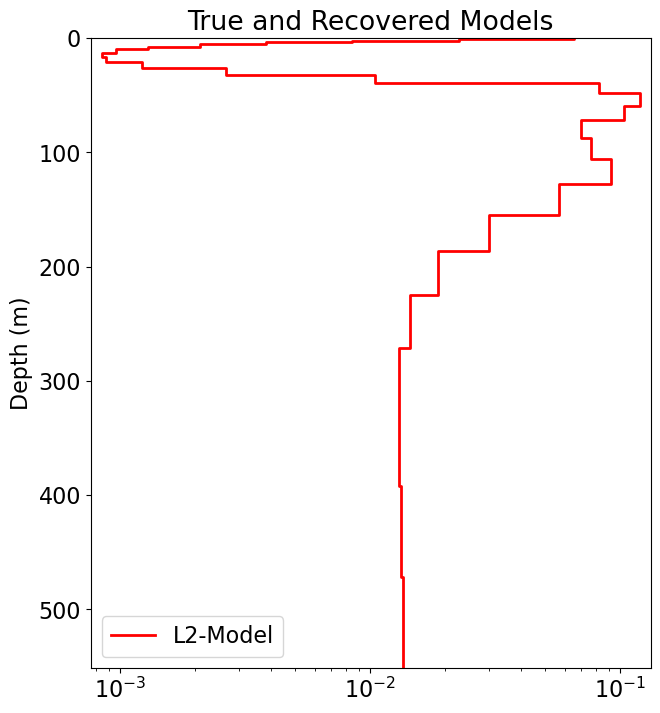

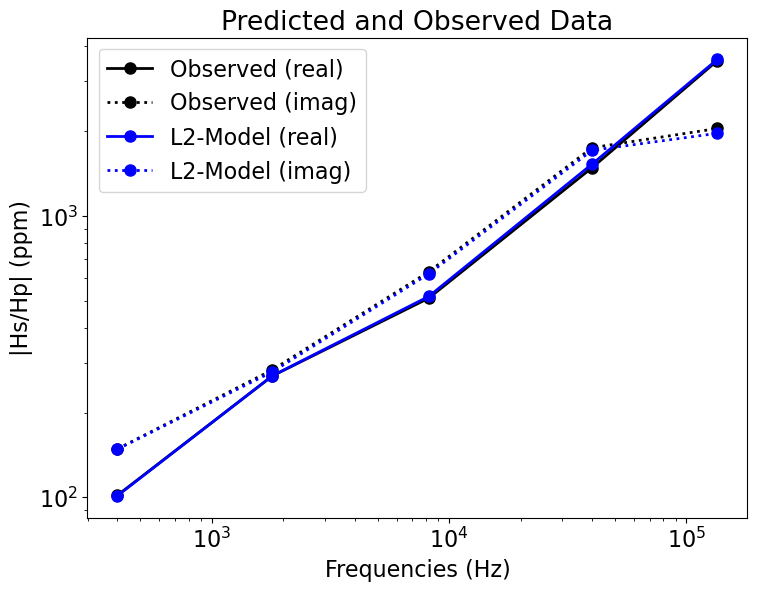

In [48]:
fig = plt.figure(figsize=(8, 9))


ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])

plot_1d_layer_model(
    regularization_mesh.h[0], log_conductivity_map  * recovered_model_L2, ax=ax1, show_layers=False, color="r"#, plot_elevation = True
)

#ax1.set_xlim(0.01, 10)
ax1.set_title("True and Recovered Models")
ax1.legend(["L2-Model", "Sparse Model"])
#plt.gca().invert_yaxis()

# Plot predicted and observed data
dpred_l2 = simulation_L2.dpred(recovered_model_L2)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(frequencies, np.abs(dobs[0::2]), "k-o")
ax1.loglog(frequencies, np.abs(dobs[1::2]), "k:o")
ax1.loglog(frequencies, np.abs(dpred_l2[0::2]), "b-o")
ax1.loglog(frequencies, np.abs(dpred_l2[1::2]), "b:o")
ax1.set_xlabel("Frequencies (Hz)")
ax1.set_ylabel("|Hs/Hp| (ppm)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(
    [
        "Observed (real)",
        "Observed (imag)",
        "L2-Model (real)",
        "L2-Model (imag)",
        "Sparse (real)",
        "Sparse (imag)",
    ],
    loc="upper left",
)
plt.show()

# Sparse Inversion

## Defining a 1D Layered Earth (1D Tensor Mesh)

In [51]:
# Same as L2 inversion
#inv_thicknesses = layer_thicknesses

#Defining mapping? 
#model_mapping = maps.ExpMap()
#model_mapping = log_conductivity_map 

## Set Prior Model

In [53]:
# Set as same halfsapace sparse regularization
#starting_model  = reference_conductivity_model

## Forward simulation

In [55]:
#Set sparse simulation
simulation_Sp = fdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, sigmaMap=log_conductivity_map
)

## Data Misfit

In [57]:
# Set data misfit
dmis_Sp = data_misfit.L2DataMisfit(simulation=simulation_Sp, data=data_object)

## Regularization

In [59]:
# Set Regularization mesh same as L2

#mesh = regularization_mesh

# Define regularization
reg_Sp = regularization.Sparse(
        regularization_mesh,
        reference_model=reference_conductivity_model
    )

#Define regulatization parameters

#PLay with 1D alpha values, and parameters
reg_Sp.alpha_s= 1e-6
reg_Sp.alpha_x=1.0

#Define sparse and blocky norms
reg_Sp.norms = [0,0]


## Optimization

In [61]:
# Gauss-Newton approach that employs the conjugate gradient solver.
opt_Sp = optimization.InexactGaussNewton(maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3)

## Inversion Parameters

In [63]:
inv_prob_Sp = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

#Inversion Directives
sensitivity_weights = directives.UpdateSensitivityWeights()
update_jacobi = directives.UpdatePreconditioner()
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)
#beta_schedule = directives.BetaSchedule(coolingFactor=1.5, coolingRate=2)
#target_misfit = directives.TargetMisfit(chifact=1.0)
#save_L2 = directives.SaveOutputDictEveryIteration()

# Directive for the IRLS 
update_IRLS = directives.UpdateIRLS(cooling_rate =2, cooling_factor=1.5, max_irls_iterations=100)


directives_list_Sp = [
    sensitivity_weights,
    update_IRLS, 
    update_jacobi,
    starting_beta,
    #beta_schedule,
    #target_misfit,
    sensitivity_weights
]

In [64]:
# Post error on mattermost?, the error when using UpdateIRLS

## Running Inversion

In [66]:
# Combine the inverse problem and the set of directives
inv_Sp = inversion.BaseInversion(inv_prob_Sp, directives_list_Sp)

# Run the inversion
# print(f"\n **** Running layered inversion for line {line_no} and station {stn}... ****")
recovered_model_Sp = inv_Sp.run(starting_conductivity_model)


/opt/anaconda3/lib/python3.12/site-packages/simpeg/directives/directives.py:325: UserWarning: InversionDirective UpdateSensitivityWeights has switched to a new inversion.
  d.inversion = i


The callback on the InexactGaussNewton Optimization was replaced.

Running inversion with SimPEG v0.23.1.dev1+g60e0c3a5

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.75e+03  3.32e+03  6.67e-32  3.32e+03    7.88e+02      0              
   1  2.75e+03  1.35e+03  5.67e-02  1.50e+03    7.44e+02      0              
   2  1.83e+03  4.49e+02  5.44e-02  5.48e+02    4.38e+02      0              
   3  1.83e+03  2.65e+02  8.26e-02  4.17e+02    4.42e+01      0              
   4  1.22e+03  2.72e+02  7.73e-02  3.67e+02    6.40e+01      0      

## Plotting results

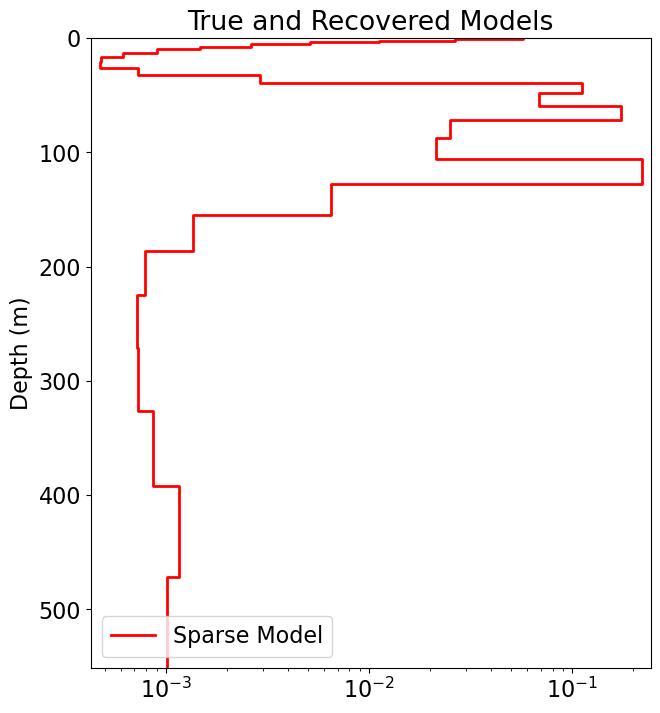

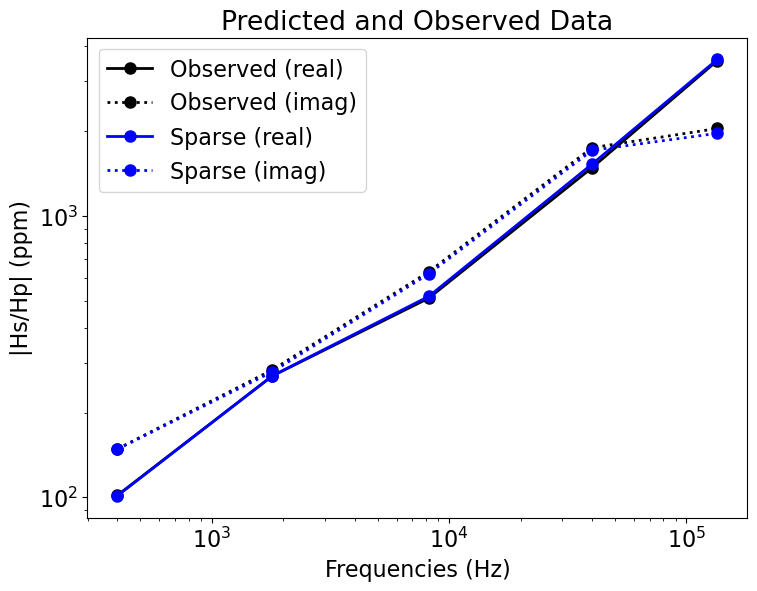

In [68]:
fig = plt.figure(figsize=(8, 9))


ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])

plot_1d_layer_model(
    regularization_mesh.h[0], log_conductivity_map  * recovered_model_Sp, ax=ax1, show_layers=False, color="r"
)

#ax1.set_xlim(0.01, 10)
ax1.set_title("True and Recovered Models")
ax1.legend(["Sparse Model"])
#plt.gca().invert_yaxis()

# Plot predicted and observed data
dpred_Sp = simulation_L2.dpred(recovered_model_L2)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(frequencies, np.abs(dobs[0::2]), "k-o")
ax1.loglog(frequencies, np.abs(dobs[1::2]), "k:o")
ax1.loglog(frequencies, np.abs(dpred_Sp[0::2]), "b-o")
ax1.loglog(frequencies, np.abs(dpred_Sp[1::2]), "b:o")
ax1.set_xlabel("Frequencies (Hz)")
ax1.set_ylabel("|Hs/Hp| (ppm)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(
    [
        "Observed (real)",
        "Observed (imag)",
        "Sparse (real)",
        "Sparse (imag)",
    ],
    loc="upper left",
)
plt.show()